# 5.9 学習の早期終了と学習率減衰 p.338

## TensorFlow スタイルのプログラム

<a href="../html/tf2_book4_ch05_02b.html"> 5.2 ImageDataGenerator によるデータ拡張処理 (b)</a>
の例を扱う。

## 5.2 (b) の内容

In [1]:
# 5-02-12 CIFAR-10 データセットの読み込み
# p.299

from tensorflow import keras
from tensorflow.keras import datasets

(x_train, t_train), (x_test, t_test) = datasets.cifar10.load_data()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [2]:
# p.299

from tensorflow.keras import layers

class CNN(keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        weight_decay = 1e-4
        self.c1 = layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            padding='same',
            input_shape=x_train[0].shape,
            kernel_regularizer=keras.regularizers.l2(weight_decay), 
            activation='relu'
            )
        self.p1 = layers.MaxPooling2D(pool_size=(2, 2))
        self.c2 = layers.Conv2D(
            filters=128,
            kernel_size=(3, 3),
            padding='same',
            kernel_regularizer=keras.regularizers.l2(weight_decay), 
            activation='relu'
            )
        self.p2 = layers.MaxPooling2D(pool_size=(2, 2))
        self.c3 = layers.Conv2D(
            filters=256,
            kernel_size=(3, 3),
            padding='same',
            kernel_regularizer=keras.regularizers.l2(weight_decay), 
            activation='relu'
            )
        self.p3 = layers.MaxPooling2D(pool_size=(2, 2))
        self.f1 = layers.Flatten()
        self.d1 = layers.Dropout(0.4)
        self.l1 = layers.Dense(512, activation='relu')
        self.l2 = layers.Dense(10, activation='softmax')
        self.ls = [ self.c1, self.p1, self.c2, self.p2, self.c3, 
                  self.p3, self.f1, self.d1, self.l1, self.l2 ]
        
    def call(self, x):
        for layer in self.ls:
            x = layer(x)
        return x

In [3]:
# 5-02-14 損失関数の定義
# p.303

cce = keras.losses.SparseCategoricalCrossentropy()

def loss(t, y):
    return cce(t, y)

In [4]:
# 5-02-15 オプティマイザー、損失と精度の記録
# p.303

optimizer = keras.optimizers.SGD(learning_rate=0.1)

train_loss = keras.metrics.Mean()
train_acc = keras.metrics.SparseCategoricalAccuracy()
val_loss = keras.metrics.Mean()
val_acc = keras.metrics.SparseCategoricalAccuracy()

In [5]:
# 5-02-16 パラメータの更新処理
# p.304

import tensorflow as tf

def train_step(x, t):
    with tf.GradientTape() as tape:
        outputs = model(x)
        tmp_loss = loss(t, outputs)
    grads = tape.gradient(tmp_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(tmp_loss)
    train_acc(t, outputs)

In [6]:
# 5-02-17 検証データでモデルを評価する
# p.305

def val_step(x, t):
    preds = model(x)
    tmp_loss = loss(t, preds)
    val_loss(tmp_loss)
    val_acc(t, preds)

## TensorFlow スタイルで学習の早期終了を行う p.338

In [7]:
# 5-09-1 学習の進捗を監視し早期終了を行うクラス
# p.338

class EarlyStopping:
    
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
          paticence (int): 監視するエポック数 (default: 10)
          verbose (int): 早期終了の出力フラグ (1:出力する, 0: 出力しない, default:0)
        '''
        self.epoch = 0
        self.pre_loss = float('inf')  # 無限大
        self.patience = patience
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
          current_loss (float): 1エポック終了後の検証データの損失
        Return:
          True: 監視回数の上限までに前エポックの損失を超えた場合
          False: 監視回数の上限までに前スポックの損失を超えない場合
        '''
        # 前エポックの損失よりも大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1
            if self.epoch > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self.epoch = 0
            self.pre_loss = current_loss
        return False

In [8]:
# 5-09-2 モデルを生成して学習する
# p.341

from sklearn.utils import shuffle

epochs = 100
batch_size = 64
train_steps = len(x_train) * 0.8 / batch_size
val_steps = len(x_train) * 0.2 /batch_size

history = { 'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[] }

ers = EarlyStopping(patience=20, verbose=1)

model = CNN(10)

# Data Augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
    )
training_generator = datagen.flow(
    x_train,
    t_train,
    batch_size=batch_size,
    subset='training')
validation_generator = datagen.flow(
    x_train,
    t_train,
    batch_size=batch_size,
    subset='validation'
    )

# training
for epoch in range(epochs):
    step_counter = 0
    for x_batch, t_batch in training_generator:
        train_step(x_batch, t_batch)
        step_counter += 1
        if step_counter >= train_steps:
            break;
    v_step_counter = 0
    for x_val_batch, t_val_batch in validation_generator:
        val_step(x_val_batch, t_val_batch)
        v_step_counter += 1
        if v_step_counter > val_steps:
            break;
    history['loss'].append(train_loss.result())
    history['accuracy'].append(train_acc.result())
    history['val_loss'].append(val_loss.result())
    history['val_accuracy'].append(val_acc.result())
    
    print(f'epoch: {epoch+1}  ',
          f'train_loss: {train_loss.result():.4f}  train_acc: {train_acc.result():.4f}  ',
          f'val_loss: {val_loss.result():.4f}  val_acc: {val_acc.result():.4f}')
    
    # EarlyStopping
    if ers(val_loss.result()):
        break;

epoch: 1   train_loss: 1.9581  train_acc: 0.2949   val_loss: 1.6158  val_acc: 0.4300
epoch: 2   train_loss: 1.7492  train_acc: 0.3702   val_loss: 1.5577  val_acc: 0.4464
epoch: 3   train_loss: 1.6242  train_acc: 0.4164   val_loss: 1.5019  val_acc: 0.4583
epoch: 4   train_loss: 1.5315  train_acc: 0.4511   val_loss: 1.4194  val_acc: 0.4889
epoch: 5   train_loss: 1.4528  train_acc: 0.4804   val_loss: 1.3489  val_acc: 0.5160
epoch: 6   train_loss: 1.3886  train_acc: 0.5046   val_loss: 1.2940  val_acc: 0.5365
epoch: 7   train_loss: 1.3315  train_acc: 0.5252   val_loss: 1.2447  val_acc: 0.5550
epoch: 8   train_loss: 1.2816  train_acc: 0.5437   val_loss: 1.2082  val_acc: 0.5691
epoch: 9   train_loss: 1.2376  train_acc: 0.5597   val_loss: 1.1721  val_acc: 0.5825
epoch: 10   train_loss: 1.1979  train_acc: 0.5743   val_loss: 1.1401  val_acc: 0.5938
epoch: 11   train_loss: 1.1618  train_acc: 0.5875   val_loss: 1.1122  val_acc: 0.6046
epoch: 12   train_loss: 1.1291  train_acc: 0.5993   val_loss: 1

In [11]:
# 5-02-23 損失と精度の推移をグラフにする
# p.317
# [自分へのメモ] 独自のコードで書き直した。さらに今回はhistory.history を history に変更した。

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(6*2, 4))
    
    ax[0].plot(history['accuracy'], "-", label="accuracy",c="blue")
    ax[0].plot(history['val_accuracy'], "-", label="val_accuracy",c="green")
    ax[0].set_title('model accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(loc="lower right")
    
    ax[1].plot(history['loss'], "-", label="loss", c="blue")
    ax[1].plot(history['val_loss'], "-", label="val_loss", c="green")
    ax[1].set_title('model loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(loc="upper left")

    plt.subplots_adjust(wspace=0.1)
    plt.show()

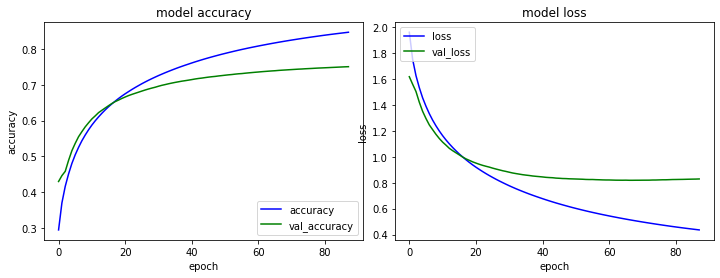

In [12]:
plot_history(history)

In [16]:
# 学習結果を評価する
# [自分へのメモ] 学習時に ImageDataGenerator で rescale=1.0/255.0としているので、x_testデータを 255 で割る必要がある

test_loss = keras.metrics.Mean()
test_acc = keras.metrics.SparseCategoricalAccuracy()

test_preds = model(x_test.astype('float32')/255)

tmp_loss = loss(t_test, test_preds)
test_loss(tmp_loss)
test_acc(t_test, test_preds)

print(f'test_loss: {test_loss.result():.4f}  test_acc: {test_acc.result():.4f}')

test_loss: 0.8403  test_acc: 0.8144
